# Notebook to make Fig. 4

In [1]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import pylab

import json
import random
import sys 
import os
import math

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.lines import Line2D

from fig_helper_functions import *

style.use('plotting.mplstyle')

### Load data

In [2]:
# Load in the predicted and observed draws 
date = '092823'
model = 'betaPlusGaussian'
f_root = '../Data/PopulationInferenceOutput/for_pp_plots/'
with open(f_root+f'{date}_{model}_pred_vs_obs_spins_dict_pp.json', 'r') as f: 
    pred_vs_obs_spins = json.load(f)

### Make Figure 4a

In [3]:
# Labels corresponding to each pop
labels_dict = {
    'pop3':r'$\mathrm{\textsc{LowSpinAligned}}$'
}

# Colors corresponding to different numbers of events
nevents_colors_dict = {
    '70events':'#d0856a', 
    '300events':'#B13306', 
}

# Parameter labels
param_lbls = {
    'chi':{'param':r'$\chi$', 'ticks':[int(0), 0.5, int(1)]}, 
    'cost':{'param':r'$\cos\theta$', 'ticks':[-int(1), int(0), int(1)]}, 
    'chieff':{'param':r'$\chi_\mathrm{eff}$', 'ticks':[-0.5, int(0), 0.5]}, 
    'chip':{'param':r'$\chi_\mathrm{p}$', 'ticks':[int(0), 0.5, int(1)]}
    
}

# For legend
legend_handles = [Line2D([], [], color=c, label=l[:-6]+' '+l[-6:]) for l,c in nevents_colors_dict.items()]

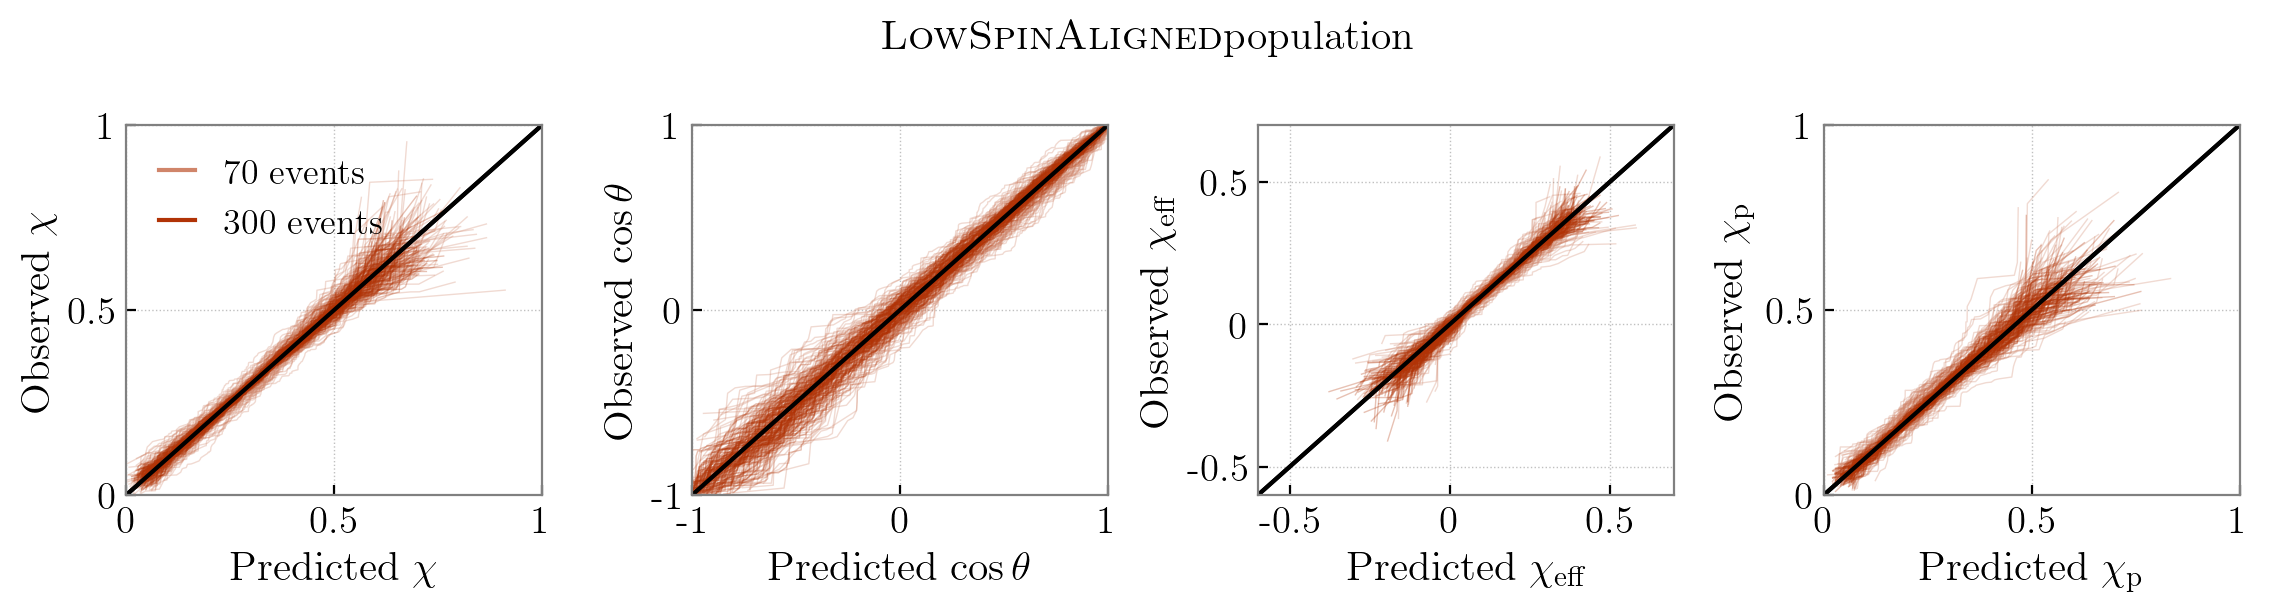

In [12]:
nCatalogs_to_plot = 100
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15/1.1, 25/8/1.3))

for i,key in enumerate(labels_dict.keys()):
            
    ax0, ax1, ax2, ax3 = axes[0], axes[1], axes[2], axes[3]
    
    for nkey in nevents_colors_dict.keys():
        
        kws = dict(alpha=0.3, c=nevents_colors_dict[nkey], lw=0.5)
            
        # spin magnitudes
        for j in range(nCatalogs_to_plot):
            chi_pred = np.concatenate((pred_vs_obs_spins[key][nkey]['bilby_posterior']['predicted']['chi1'][j], 
                                       pred_vs_obs_spins[key][nkey]['bilby_posterior']['predicted']['chi2'][j]))
            chi_obs = np.concatenate((pred_vs_obs_spins[key][nkey]['bilby_posterior']['observed']['chi1'][j], 
                                      pred_vs_obs_spins[key][nkey]['bilby_posterior']['observed']['chi2'][j]))
            ax0.plot(np.sort(chi_pred), np.sort(chi_obs), **kws)
        ax0.plot([0, 1], [0, 1], color='k') # diagonal line
        ax0.set_xlim(0,1)
        ax0.set_ylim(0,1)

        # tilt angles
        for j in range(nCatalogs_to_plot):
            cost_pred = np.concatenate((pred_vs_obs_spins[key][nkey]['bilby_posterior']['predicted']['cost1'][j], 
                                        pred_vs_obs_spins[key][nkey]['bilby_posterior']['predicted']['cost2'][j]))
            cost_obs = np.concatenate((pred_vs_obs_spins[key][nkey]['bilby_posterior']['observed']['cost1'][j], 
                                       pred_vs_obs_spins[key][nkey]['bilby_posterior']['observed']['cost2'][j]))
            ax1.plot(np.sort(cost_pred), np.sort(cost_obs), **kws)
        ax1.plot([-1, 1], [-1, 1], color='k')
        ax1.set_xlim(-1,1)
        ax1.set_ylim(-1,1)

        # chieff
        for j in range(nCatalogs_to_plot):
            ax2.plot(np.sort(pred_vs_obs_spins[key][nkey]['bilby_posterior']['predicted']['chieff'][j]), 
                            np.sort(pred_vs_obs_spins[key][nkey]['bilby_posterior']['observed']['chieff'][j]), **kws)
        ax2.plot([-1, 1], [-1, 1], color='k')
        ax2.set_xlim(-0.6, 0.7)
        ax2.set_ylim(-0.6, 0.7)

        # chip
        for j in range(nCatalogs_to_plot):
            ax3.plot(np.sort(pred_vs_obs_spins[key][nkey]['bilby_posterior']['predicted']['chip'][j]), 
                            np.sort(pred_vs_obs_spins[key][nkey]['bilby_posterior']['observed']['chip'][j]), **kws)
        ax3.plot([0, 1], [0, 1], color='k')
        ax3.set_xlim(0,1)
        ax3.set_ylim(0,1)


# Axes labels
for ax,pk in zip([ax0, ax1, ax2, ax3],param_lbls.keys()): 
    p = param_lbls[pk]['param']
    ax.set_ylabel('Observed '+p, fontsize=15)
    ax.set_xlabel('Predicted '+p, fontsize=15)


# Add legend
axes[0].legend(handles=legend_handles, loc='upper left', handlelength=1, fontsize=13)

# Grid
for ax in axes: 
    ax.grid(ls=':', color='silver', lw=0.5)
    ax.spines['bottom'].set_color('gray')
    ax.spines['top'].set_color('gray') 
    ax.spines['right'].set_color('gray')
    ax.spines['left'].set_color('gray')
    
    
# Axes formatting 
for ax,pk in zip([ax0, ax1, ax2, ax3],param_lbls.keys()): 
    ticks = param_lbls[pk]['ticks']
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks)

plt.subplots_adjust(wspace=0.36)

plt.suptitle(labels_dict['pop3']+ 'population', fontsize=15, y=1.1)

plt.savefig('figure_04a.pdf', bbox_inches='tight')
plt.show()

### Calculate fraction over/underpredicted from PP plots for each catalog as a function of predicted spin

In [5]:
poplist = ['pop3']
percentages_dict = {}

for pop,pop_key in enumerate(poplist):    
    percentages_dict_pop = {}
    
    for nevents_key in ['70events', '300events']:
        
        print(pop_key, nevents_key)
        
        # data for this run
        d = pred_vs_obs_spins[pop_key][nevents_key]['bilby_posterior']
        
        # function in figure_helper_functions
        percentages_dict_pop[nevents_key] = get_fraction_underpredicted(d, nTrials=10)[1]
                
    percentages_dict[pop_key] = percentages_dict_pop
    
print('Done!')

pop3 70events


/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret 

pop3 300events
Done!


### Make figure 4b

/local/simona.miller/ipykernel_3409250/742861665.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '0.25', '0.5', '0.75', '1'])


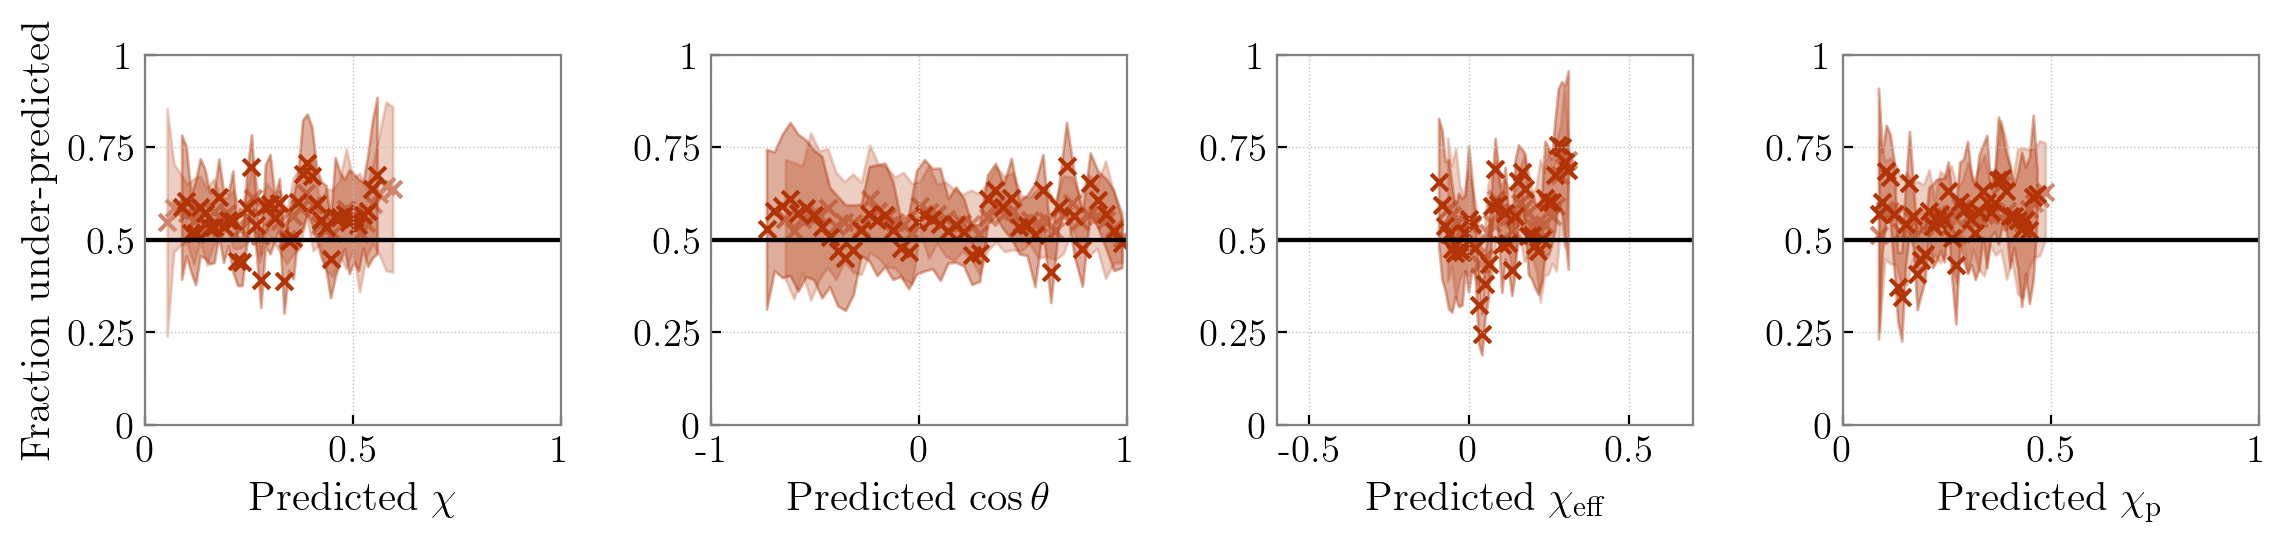

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15/1.1, 25/8/1.3))

for i,key in enumerate(poplist):
    
    ax0, ax1, ax2, ax3 = axes[0], axes[1], axes[2], axes[3]
    
    for nevents_key in nevents_colors_dict.keys():
    
        # spin magnitudes
        ax0.scatter(percentages_dict[key][nevents_key]['chi1']['x_vals'], 
                           percentages_dict[key][nevents_key]['chi1']['percentages'], 
                           color=nevents_colors_dict[nevents_key], marker='x')
        ax0.fill_between(percentages_dict[key][nevents_key]['chi1']['x_vals'], 
                    percentages_dict[key][nevents_key]['chi1']['percentages']+3*percentages_dict[key][nevents_key]['chi1']['error'], 
                    percentages_dict[key][nevents_key]['chi1']['percentages']-3*percentages_dict[key][nevents_key]['chi1']['error'], 
                    color=nevents_colors_dict[nevents_key], alpha=0.4)
        ax0.plot([0, 1], [0.5, 0.5], color='k') # horizontal line
        ax0.set_xlim(0,1)
        ax0.set_ylim(0,1)

        # tilt angles
        ax1.scatter(percentages_dict[key][nevents_key]['cost1']['x_vals'], 
                           percentages_dict[key][nevents_key]['cost1']['percentages'], 
                           color=nevents_colors_dict[nevents_key], marker='x')
        ax1.fill_between(percentages_dict[key][nevents_key]['cost1']['x_vals'], 
                    percentages_dict[key][nevents_key]['cost1']['percentages']+3*percentages_dict[key][nevents_key]['cost1']['error'], 
                    percentages_dict[key][nevents_key]['cost1']['percentages']-3*percentages_dict[key][nevents_key]['cost1']['error'], 
                    color=nevents_colors_dict[nevents_key], alpha=0.4)
        ax1.plot([-1, 1], [0.5, 0.5], color='k')
        ax1.set_xlim(-1,1)
        ax1.set_ylim(0,1)

        # chi eff
        ax2.scatter(percentages_dict[key][nevents_key]['chieff']['x_vals'], 
                           percentages_dict[key][nevents_key]['chieff']['percentages'], 
                           color=nevents_colors_dict[nevents_key], marker='x')
        ax2.fill_between(percentages_dict[key][nevents_key]['chieff']['x_vals'], 
                    percentages_dict[key][nevents_key]['chieff']['percentages']+3*percentages_dict[key][nevents_key]['chieff']['error'], 
                    percentages_dict[key][nevents_key]['chieff']['percentages']-3*percentages_dict[key][nevents_key]['chieff']['error'], 
                    color=nevents_colors_dict[nevents_key], alpha=0.4)
        ax2.plot([-1, 1], [0.5, 0.5], color='k')
        ax2.set_xlim(-0.6, 0.7)
        ax2.set_ylim(0,1)

        # chi p
        ax3.scatter(percentages_dict[key][nevents_key]['chip']['x_vals'], 
                           percentages_dict[key][nevents_key]['chip']['percentages'], 
                           color=nevents_colors_dict[nevents_key], marker='x')
        ax3.fill_between(percentages_dict[key][nevents_key]['chip']['x_vals'], 
                    percentages_dict[key][nevents_key]['chip']['percentages']+3*percentages_dict[key][nevents_key]['chip']['error'], 
                    percentages_dict[key][nevents_key]['chip']['percentages']-3*percentages_dict[key][nevents_key]['chip']['error'], 
                    color=nevents_colors_dict[nevents_key], alpha=0.4)
        ax3.plot([0, 1], [0.5, 0.5], color='k')
        ax3.set_xlim(0,1)
        ax3.set_ylim(0,1)
    
# set label
ax0.set_ylabel('Fraction under-predicted', fontsize=15)

ax0.set_xlabel(r'Predicted $\chi$', fontsize=15)
ax1.set_xlabel(r'Predicted $\cos\theta$', fontsize=15)
ax2.set_xlabel(r'Predicted $\chi_\mathrm{eff}$', fontsize=15)
ax3.set_xlabel(r'Predicted $\chi_\mathrm{p}$', fontsize=15)

# Grid
for ax in axes: 
    ax.grid(ls=':', color='silver', lw=0.5)
    ax.spines['bottom'].set_color('gray')
    ax.spines['top'].set_color('gray') 
    ax.spines['right'].set_color('gray')
    ax.spines['left'].set_color('gray')
    
# Axes formatting 
for ax,pk in zip([ax0, ax1, ax2, ax3],param_lbls.keys()): 
    ticks = param_lbls[pk]['ticks']
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks)
    ax.set_yticklabels(['0', '0.25', '0.5', '0.75', '1'])
            
plt.subplots_adjust(wspace=0.36)
    
plt.savefig('figure_04b.pdf',bbox_inches='tight')
plt.show()